<a href="https://colab.research.google.com/github/PietroSchgor/Bayesian-Project/blob/main/Spike%20and%20Slab/Successful%20Experiments/FINAL_Model2_order7_SpiSla_MU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/ProjectBayesianDirectory

Mounted at /gdrive
/gdrive/My Drive/ProjectBayesianDirectory


In [2]:
# Install cmdstanpy module
!pip install cmdstanpy
!pip list | grep cmdstanpy

cmdstanpy                          1.2.5


In [3]:
# Install arviz module (With version 2.33.1 you will need a special version of arviz)
!pip install arviz
!pip list | grep arviz

arviz                              0.20.0


In [4]:
# Install cmdstan -- Just for the first time!
from cmdstanpy import install_cmdstan
install_cmdstan()

CmdStan install directory: /root/.cmdstan
Installing CmdStan version: 2.36.0
Download successful, file: /tmp/tmp8yhzj9sd
Extracting distribution


DEBUG:cmdstanpy:cmd: make build -j1
cwd: None


Unpacked download as cmdstan-2.36.0
Building version cmdstan-2.36.0, may take several minutes, depending on your system.


DEBUG:cmdstanpy:cmd: make examples/bernoulli/bernoulli
cwd: None


Installed cmdstan-2.36.0
Test model compilation


True

In [5]:
from cmdstanpy import cmdstan_path
cmdstan_path()

'/root/.cmdstan/cmdstan-2.36.0'

In [6]:
# Create folder to store .stan files
import os
if not os.path.exists("./stan"):
    os.mkdir("./stan")

# Import modules
import numpy as np
import arviz as az
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Import functions
from cmdstanpy import CmdStanModel
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

# Upload data




In [8]:
y = pd.read_csv('TremorProb_3.csv')
print(y.head())

   -0.56776965264151  -0.560751922076954  -0.494744951017843  \
0           -0.56777           -0.560752           -0.494745   
1           -0.56777           -0.560752           -0.494745   
2           -0.56777           -0.560752           -0.494745   
3           -0.56777           -0.560752           -0.494745   
4           -0.56777           -0.560752           -0.494745   

   -0.592826732169969  -0.81318181652313  -0.644276223118887  \
0           -0.592827          -0.813182           -0.658020   
1           -0.592827          -0.813182           -0.666266   
2           -0.592827          -0.813182           -0.671764   
3           -0.592827          -0.813182           -0.699252   
4           -0.592827          -0.813182           -0.699252   

   0.107063287229996  -0.354234873822389  -0.293796081710556  \
0          -0.028780           -0.354235           -0.293796   
1          -0.110285           -0.354235           -0.293796   
2          -0.164623           -0.3542

In [9]:
N = y.shape[0]
d = y.shape[1]
print("Dimension is", N)
print("Sample is", d)

Dimension is 287
Sample is 45


In [10]:
x = np.linspace(0,1,N)

In [11]:
y = np.array(np.transpose(y))

In [12]:
y

array([[-0.56776965, -0.56776965, -0.56776965, ..., -0.525622  ,
        -0.51719247, -0.50454817],
       [-0.56075192, -0.56075192, -0.56075192, ..., -0.56075192,
        -0.56075192, -0.56075192],
       [-0.49474495, -0.49474495, -0.49474495, ..., -0.49474495,
        -0.49474495, -0.49474495],
       ...,
       [-0.61992127, -0.62669667, -0.6312136 , ..., -0.65379825,
        -0.65379825, -0.65379825],
       [-0.61189675, -0.61189675, -0.61189675, ..., -0.61189675,
        -0.61189675, -0.61189675],
       [-0.73499798, -0.73499798, -0.73499798, ..., -0.73499798,
        -0.73499798, -0.73499798]])

In [13]:
plt.plot(x, y[2,:])
plt.xlabel("x")
plt.ylabel("y_vectors[2]")
plt.title("Plot of y_vectors[2] vs. x")
plt.show()

# Current Model
This is the model we are going to use
$$
   \mathbf{y}_{t}(s) = \beta[1] \mu + \beta[2]\mathbf{y}_{t-1}+...+\beta[p+1]\mathbf{y}_{t-p}+ϵ \in \mathbb{R}^{N}
$$

\\
Let $\mathbf{y}_{t}(s) = (Y(\mathbf{s}, t), \dots, Y(\mathbf{s}, t)) \in \mathbb{R}^{N}$. The hierarchical bayesian model is as follows

\\

\begin{aligned}
    \mathbf{y_t} \mid \beta, \mathbf{\mu}, \boldsymbol{\tau^2}, \mathbf{y_{t-1}} &\sim \text{multivariate normal}((\beta[1] \mu + \beta[2]\mathbf{y}_{t-1}+...+\beta[p+1]\mathbf{y}_{t-p}, diag(\boldsymbol{\tau^2}))\\
    \mu &\sim \text{multivariate normal}(0,\sigma^2 \mathbf{A}(\rho))\\
    %\rho &\sim \text{InvGamma}(5, 5) \\
    \sigma &\sim \text{InvGamma}(1, 2) \\
    %\alpha &\sim \text{normal}(0, 1) \\
    \tau_s &\overset{\underset{\mathrm{i.i.d}}{}}{\sim} \text{InvGamma}(1, 2)  \    s=1,2...,N\\   
    \beta &\sim \text{Dirichlet}(3/2,3/2,...,3/2)
\end{aligned}

And
\begin{aligned}
 \mathbf{A}(\rho)_{ij} &= \frac{1}{(1-\rho^2)} \rho^{\lvert i-j \rvert}
 \end{aligned}

In [14]:
# Useful functions for the spatio-temporal model
spt_tools = \
"""
// Computes Temporal covariance kernel
matrix cov_time(int T, real rho_t) {
    matrix[T,T] cov;
    for (i in 1:T) {
        for(j in i:T) {
            cov[i,j] = rho_t^abs(i-j);
            cov[j,i] = cov[i,j];
        }
    }
    return (1/(1-rho_t^2)) * cov;
}

// Computes kronecker product between vectors
vector kron_prod(vector A, vector B){
    int N = size(A);
    int P = size(B);
    vector[N*P] kron;
    for (i in 1:N) {
        kron[((i-1)*P+1):i*P] = A[i] * B;
    }
    return kron;
}

// Computes the media for the i-day
vector media_construction (int p, int i, array[] vector Y, vector mu, vector phi){
    int N = size(mu);
    vector[N] media = rep_vector(0, N);
    if (i <= p) {
        // Caso per i primi `p` giorni
        vector[i] effective_phi = phi[1:i] / sum(phi[1:i]);
        media += effective_phi[1] * mu;
        for (lag in 1:(i - 1)) {
            media += effective_phi[lag + 1] * Y[i - lag];
        }
    } else {
        media += phi[1] * mu;
        for (lag in 1:p) {
            media += phi[lag + 1] * Y[i - lag];
        }
    }
    return media;
}
"""

# Write functions to file
stan_file = "stan/spt-tools.stan"
with open(stan_file, "w") as f:
    print(spt_tools, file=f)

generated quantities {
          vector[d] log_lik;
          for (j in 1:d) {
            vector[N] media = mario[1]*mu;
            for (lag in 1:p)
              media += mario[lag+1]*y_translated[lag][j];
            log_lik[j] = multi_normal_lpdf(Y[j] | media, diag_matrix(tau));
          }
        }

In [15]:
# ordine p - v2
synt4_fitGP_ML = """
        functions {
            #include "spt-tools.stan"
        }

        data {
          int<lower=1> d;
          int<lower=1> N;
          int<lower=1> x;     // number of time intervals
          array[d] vector[N] Y; // previous was: matrix[N,d] y;
          real<lower=0> rho;  // time innovation coefficient
          int<lower=1> p;
          vector[N] mu_obs;
          //vector<lower=0>[p+1] alpha;
        }

        transformed data {
          // Temporal covariance matrix
          matrix[N,N] Ht = cov_time(x, rho);

          // Autoregressive vector
          array[d] vector[N] y_n_1;
          array[d] vector[N] y_n_2;
          y_n_1[1] = rep_vector(0,N);
          y_n_2[1] = rep_vector(0,N);
          y_n_2[2] = rep_vector(0,N);
          y_n_1[2] = Y[1];
          for (j in 3:d) {
            y_n_1[j] = Y[j - 1];
            y_n_2[j] = Y[j - 2];
          }

          // array[p] array[d] vector[N] y_translated;
          array[p,d] vector[N] y_translated;
          for (lag in 1:p){
            for (day in 1:lag)
              // y_translated[lag][day] = rep_vector(0,N);
              y_translated[lag][day] = to_vector(normal_rng(rep_vector(0, N), rep_vector(sqrt(0.1 * day), N)))+Y[1];
            for (day in lag+1 :d)
              y_translated[lag][day] = Y[day - lag];
          }
        }

        parameters {
          real<lower=0> sigmat;
          vector<lower=0>[N] tau;
          vector[N] mu;
          simplex[p+1] mario;
          //real<lower=0> alpha_1;
          //real<lower=alpha_1> alpha_2;
          vector<lower=0, upper=1>[p+1] gamma;
        }

        transformed parameters {

            // Mean vector
            //vector[N] media = mario[1]*mu + mario[2]*y_n_1+ mario[3]*y_n_2;

            // Temporal Covariance Matrix
            matrix[N,N] Sigma_t = sigmat * sigmat * Ht;
            matrix[N,N] Lalpha = cholesky_decompose(Sigma_t);
        }

        model {
          // Likelihood
          for (i in 1:d) {
            vector[N] media = mario[1]*mu;
            for (lag in 1:p)
              media += mario[lag+1]*y_translated[lag][i];
            Y[i][1:N] ~ normal(media[1:N], tau[1:N]);
          }
          // in case previous don't work Y_vect[1:N*d] ~ normal(media[1:N*d], tau_kro[1:N*d]);

          //Priors
          mu ~ multi_normal_cholesky(mu_obs, Lalpha);
          sigmat ~ inv_gamma(2, 1);
          tau ~ inv_gamma(2, 1);

          for (k in 1:(p+1)) {
              target += log_mix(gamma[k], normal_lpdf(mario[k] | 0, 0.01),
                                      normal_lpdf(mario[k] | 0, 4));
          }
          //alpha_1 ~ normal(0, 0.01); //change to gamma or fix
          //alpha_2 ~ normal(0, 4); //change to gamma or fix
          gamma ~ beta(1, 1);

        }

        generated quantities {
          vector[d] log_lik;
          for (j in 1:d) {
            vector[N] media = mario[1]*mu;
            for (lag in 1:p)
              media += mario[lag+1]*y_translated[lag][j];
            log_lik[j] = multi_normal_lpdf(Y[j] | media, diag_matrix(tau));
          }
        }

"""
# Write model to file
stan_file = "./stan/synt5GP_fitML.stan"
with open(stan_file, "w") as f:
    print(synt4_fitGP_ML, file=f)

# Compile stan model
stan_model = CmdStanModel(stan_file=stan_file)

DEBUG:cmdstanpy:Removing /gdrive/MyDrive/ProjectBayesianDirectory/stan/synt5GP_fitML
11:18:58 - cmdstanpy - INFO - compiling stan file /gdrive/MyDrive/ProjectBayesianDirectory/stan/synt5GP_fitML.stan to exe file /gdrive/MyDrive/ProjectBayesianDirectory/stan/synt5GP_fitML
INFO:cmdstanpy:compiling stan file /gdrive/MyDrive/ProjectBayesianDirectory/stan/synt5GP_fitML.stan to exe file /gdrive/MyDrive/ProjectBayesianDirectory/stan/synt5GP_fitML
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=synt5GP_fitML.stan STANCFLAGS+=--include-paths=/gdrive/MyDrive/ProjectBayesianDirectory/stan /gdrive/MyDrive/ProjectBayesianDirectory/stan/synt5GP_fitML
cwd: /root/.cmdstan/cmdstan-2.36.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=synt5GP_fitML.stan --include-paths=/gdrive/MyDrive/ProjectBayesianDirectory/stan --o=/gdrive/MyDrive/ProjectBayesianDirectory/stan/synt5GP_fitML.hpp /gdrive/MyDrive/ProjectBayesianDirectory/stan/synt5GP_fitML

In [16]:
y.shape

(45, 287)

In [20]:
mu_obs = np.load('mu_obs.npy')

In [21]:
mu_obs = mu_obs[1:]
mu_obs.shape

(287,)

In [22]:
# Prepare data list for stan
input_data = {
    "d": d,
    "N": N,
    "x": 287,
    "Y": y,
    "rho": 0.5,
    "p": 7,
    "mu_obs": mu_obs
    #"alpha" : [1.5,1.5,1.5,1.5]
}
#specify with the same names you put in data!

# Run the sampler
stan_fit = stan_model.sample(data=input_data, chains=4, parallel_chains=4,
                             iter_warmup=300, iter_sampling=1000)

# Convert chain to arviz format
cmdstanpy_data = az.from_cmdstanpy(stan_fit)

DEBUG:cmdstanpy:cmd: /gdrive/MyDrive/ProjectBayesianDirectory/stan/synt5GP_fitML info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmp33ye388h/lrp9isi5.json
11:22:16 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/gdrive/MyDrive/ProjectBayesianDirectory/stan/synt5GP_fitML', 'id=1', 'random', 'seed=48683', 'data', 'file=/tmp/tmp33ye388h/lrp9isi5.json', 'output', 'file=/tmp/tmp33ye388h/synt5GP_fitMLvt1byv4j/synt5GP_fitML-20250206112216_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=300', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/gdrive/MyDrive/ProjectBayesianDirectory/stan/synt5GP_fitML', 'id=2', 'random', 'seed=48683', 'data', 'file=/tmp/tmp33ye388h/lrp9isi5.json', 'output', 'file=/tmp/tmp33ye388h/synt5GP_fitMLvt1byv4j/synt5GP_fitML-20250206112216_2.csv', 'method=sample', 'num_samples=1000', 'num_warmup=300', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/gdrive/MyDrive/ProjectBayesianDirectory

11:59:08 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/gdrive/MyDrive/ProjectBayesianDirectory/stan/synt5GP_fitML', 'id=1', 'random', 'seed=48683', 'data', 'file=/tmp/tmp33ye388h/lrp9isi5.json', 'output', 'file=/tmp/tmp33ye388h/synt5GP_fitMLvt1byv4j/synt5GP_fitML-20250206112216_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=300', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp33ye388h/synt5GP_fitMLvt1byv4j/synt5GP_fitML-20250206112216_1.csv
 console_msgs (if any):
	/tmp/tmp33ye388h/synt5GP_fitMLvt1byv4j/synt5GP_fitML-20250206112216_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 1000 (Default)
    num_warmup = 300
    save_warmup = false (Default)
    thin = 1 (Default)
    adapt
      engaged = true (Defa

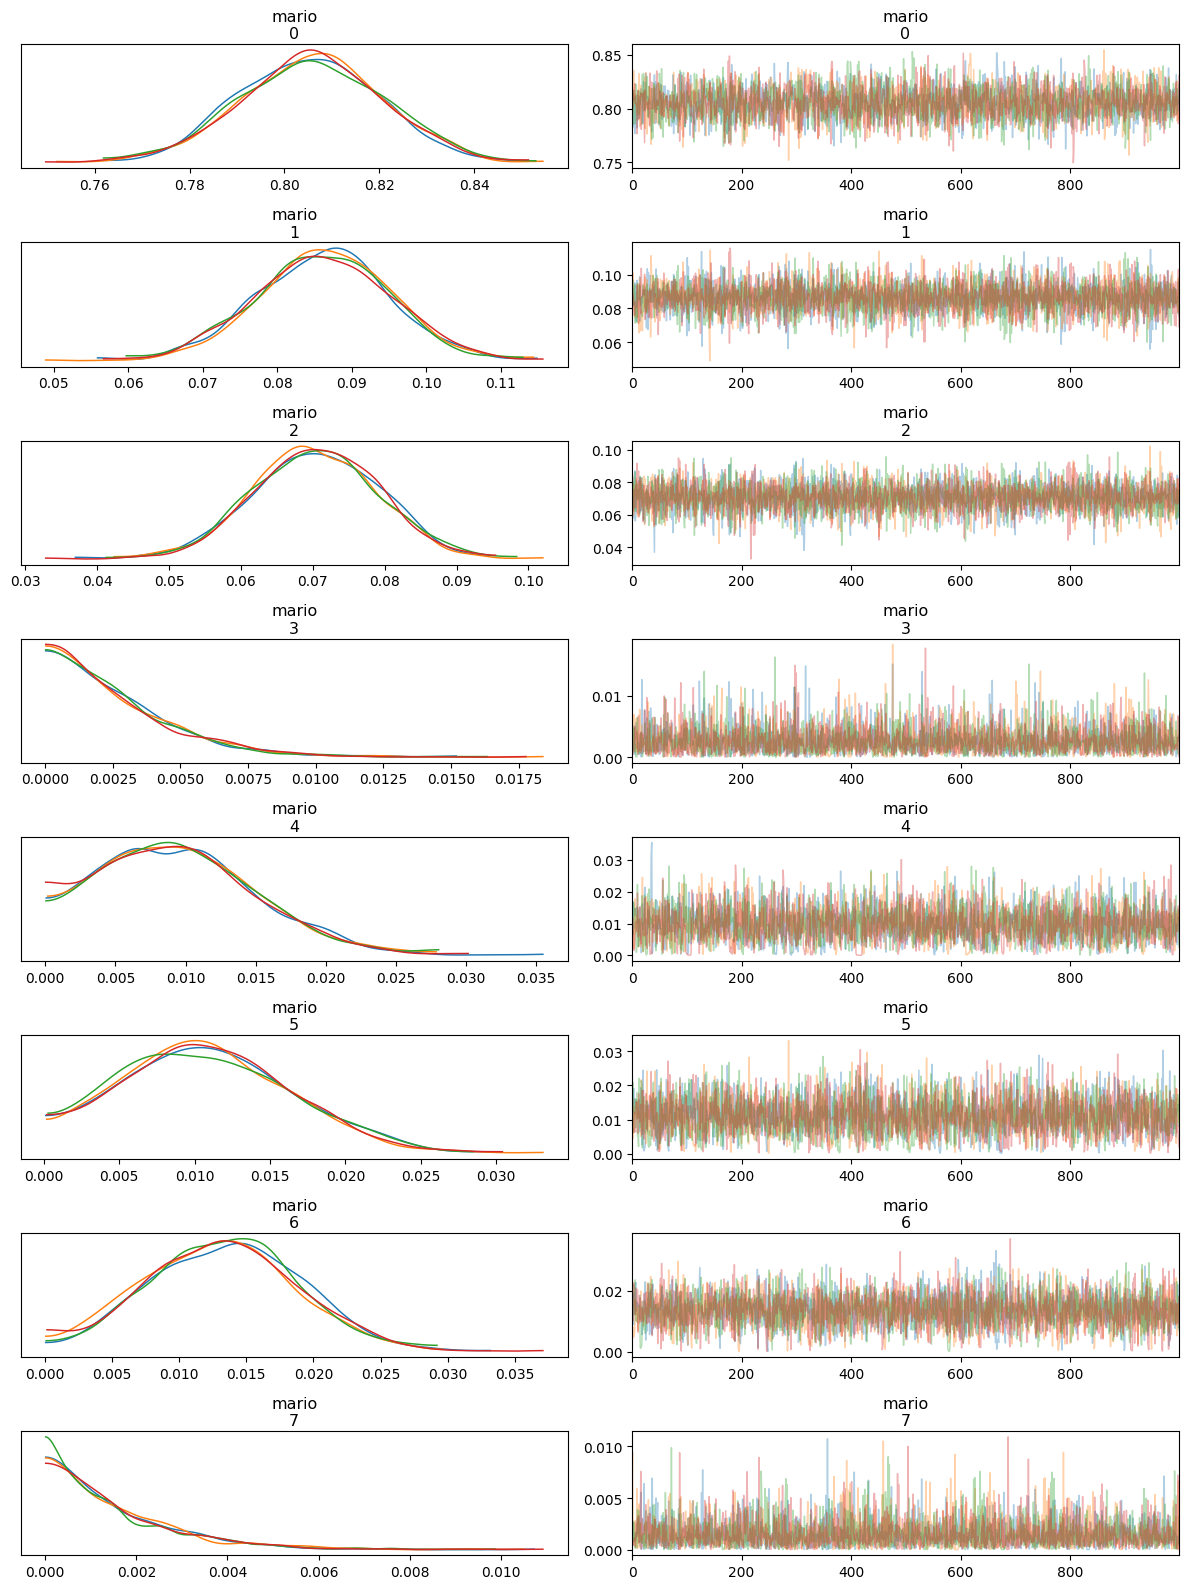

In [23]:
# az.plot_trace(cmdstanpy_data['posterior']['beta'], compact=False)
az.plot_trace(cmdstanpy_data['posterior']['mario'], compact=False)
plt.tight_layout()
plt.show()

In [24]:
print(np.mean(cmdstanpy_data['posterior']['mario'][:,:,0]))
print(np.mean(cmdstanpy_data['posterior']['mario'][:,:,1]))
print(np.mean(cmdstanpy_data['posterior']['mario'][:,:,2]))
print(np.mean(cmdstanpy_data['posterior']['mario'][:,:,3]))
print(np.mean(cmdstanpy_data['posterior']['mario'][:,:,4]))
print(np.mean(cmdstanpy_data['posterior']['mario'][:,:,5]))
print(np.mean(cmdstanpy_data['posterior']['mario'][:,:,6]))
print(np.mean(cmdstanpy_data['posterior']['mario'][:,:,7]))

<xarray.DataArray 'mario' ()> Size: 8B
array(0.80558162)
Coordinates:
    mario_dim_0  int64 8B 0
<xarray.DataArray 'mario' ()> Size: 8B
array(0.08616765)
Coordinates:
    mario_dim_0  int64 8B 1
<xarray.DataArray 'mario' ()> Size: 8B
array(0.07040851)
Coordinates:
    mario_dim_0  int64 8B 2
<xarray.DataArray 'mario' ()> Size: 8B
array(0.00266923)
Coordinates:
    mario_dim_0  int64 8B 3
<xarray.DataArray 'mario' ()> Size: 8B
array(0.00954463)
Coordinates:
    mario_dim_0  int64 8B 4
<xarray.DataArray 'mario' ()> Size: 8B
array(0.01083379)
Coordinates:
    mario_dim_0  int64 8B 5
<xarray.DataArray 'mario' ()> Size: 8B
array(0.01326704)
Coordinates:
    mario_dim_0  int64 8B 6
<xarray.DataArray 'mario' ()> Size: 8B
array(0.00152754)
Coordinates:
    mario_dim_0  int64 8B 7


In [25]:

# Assuming cmdstanpy_data is your InferenceData object
for dimension in range(8):
    mario_data = cmdstanpy_data['posterior']['mario'][:,:,dimension]

    # Calculate the lower and upper bounds of the 90% credibility interval
    lower_bound = np.percentile(mario_data, 5)  # 5th percentile
    upper_bound = np.percentile(mario_data, 95) # 95th percentile

    print(f"90% Credibility Interval for mario[:,:,{dimension}]: [{lower_bound:.4f}, {upper_bound:.4f}]")

90% Credibility Interval for mario[:,:,0]: [0.7811, 0.8309]
90% Credibility Interval for mario[:,:,1]: [0.0712, 0.1007]
90% Credibility Interval for mario[:,:,2]: [0.0565, 0.0845]
90% Credibility Interval for mario[:,:,3]: [0.0002, 0.0072]
90% Credibility Interval for mario[:,:,4]: [0.0015, 0.0193]
90% Credibility Interval for mario[:,:,5]: [0.0022, 0.0206]
90% Credibility Interval for mario[:,:,6]: [0.0043, 0.0225]
90% Credibility Interval for mario[:,:,7]: [0.0001, 0.0044]


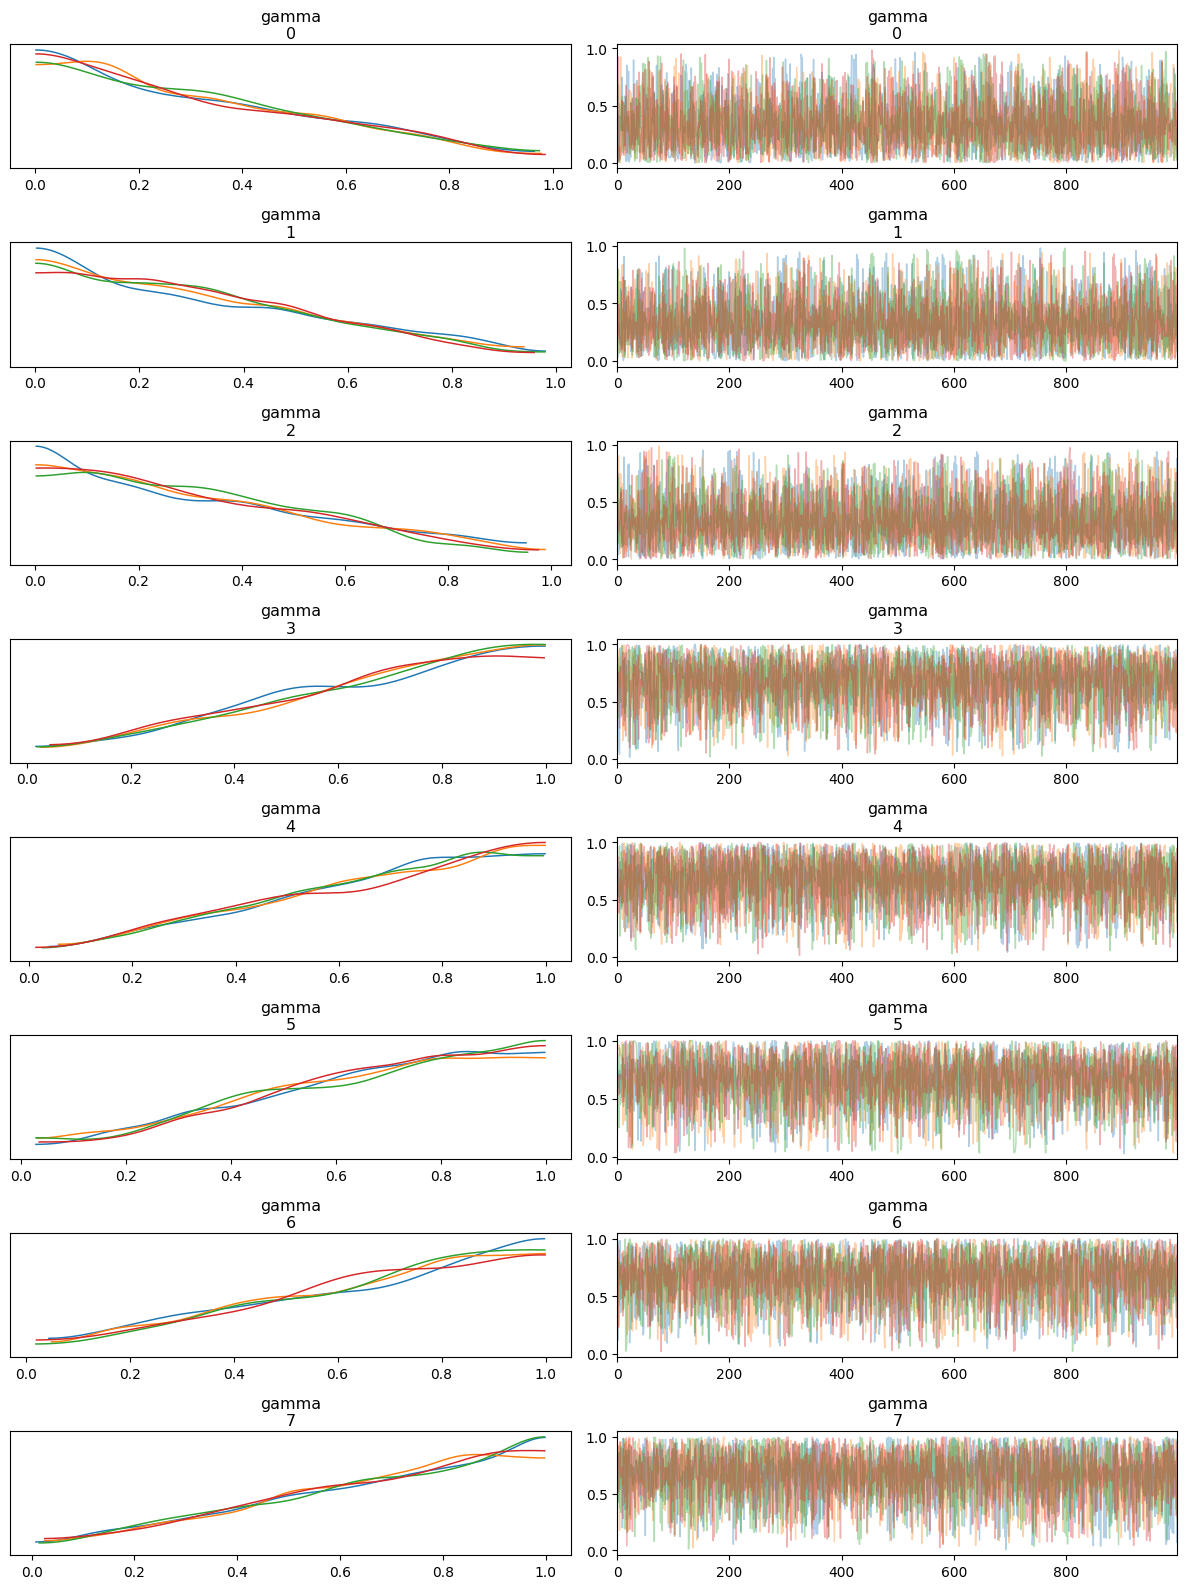

In [26]:
az.plot_trace(cmdstanpy_data['posterior']['gamma'], compact=False)
plt.tight_layout()
plt.show()

In [27]:
gamma_data = cmdstanpy_data['posterior']['gamma']

for dimension in range(8):
    # Extract the data for the current dimension
    dimension_data = gamma_data[:,:,dimension]

    # Calculate the percentage of values less than 0.5
    percentage = np.mean(dimension_data < 0.5) * 100

    print(f"Percentage of values less than 0.5 in dimension {dimension}: {percentage:.2f}%")

Percentage of values less than 0.5 in dimension 0: 73.88%
Percentage of values less than 0.5 in dimension 1: 74.78%
Percentage of values less than 0.5 in dimension 2: 74.42%
Percentage of values less than 0.5 in dimension 3: 25.20%
Percentage of values less than 0.5 in dimension 4: 25.70%
Percentage of values less than 0.5 in dimension 5: 26.07%
Percentage of values less than 0.5 in dimension 6: 25.90%
Percentage of values less than 0.5 in dimension 7: 25.47%


In [28]:
az.plot_trace(cmdstanpy_data['posterior']['sigmat'], compact=False)
plt.tight_layout()
plt.show()

In [29]:
az.plot_trace(cmdstanpy_data['posterior']['tau'], compact=False)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (287), generating only 20 plots
  warnings.warn(


In [30]:
az.plot_trace(cmdstanpy_data['posterior']['mu'], compact=False)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (287), generating only 20 plots
  warnings.warn(


# WAIC and BF COMPUTATION

In [31]:
print("GLM-WAIC: ", az.waic(cmdstanpy_data, var_name="log_lik"))

GLM-WAIC:  Computed from 4000 posterior samples and 45 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -12970.61   218.60
p_waic      278.29        -

There has been a warning during the calculation. Please check the results.


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


In [32]:
print("GLM-LOO: ", az.loo(cmdstanpy_data, var_name="log_lik"))

KeyboardInterrupt: 

In [ ]:
order3_log_lik = cmdstanpy_data.log_likelihood.log_lik

In [ ]:
log_marginal_lik_order3 = np.log(np.mean(np.exp(order3_log_lik - np.max(order3_log_lik)))) + np.max(order3_log_lik)
log_marginal_lik_order3

In [ ]:
np.save('log_marginal_lik_order3.npy', log_marginal_lik_order3)

In [ ]:
# BF ....
log_marginal_lik_order1 = np.load('log_marginal_lik_full.npy')
log_marginal_lik_null = np.load('log_marginal_lik_null.npy')
log_marginal_lik_order2 = np.load('log_marginal_lik_order2.npy')

In [ ]:
bayes_factor = np.exp(log_marginal_lik_null - log_marginal_lik_order3)
print(f"Bayes Factor (BF_01): {bayes_factor}")

In [ ]:
bayes_factor = np.exp(log_marginal_lik_order1 - log_marginal_lik_order3)
print(f"Bayes Factor (BF_01): {bayes_factor}")

In [ ]:
bayes_factor = np.exp(log_marginal_lik_order2 - log_marginal_lik_order3)
print(f"Bayes Factor (BF_01): {bayes_factor}")

# PREDICTION CHECK

In [ ]:
#betas = cmdstanpy_data['posterior']['beta'][3]
taus = cmdstanpy_data['posterior']['tau'][3]
mus = cmdstanpy_data['posterior']['mu'][3]
#sigmas = cmdstanpy_data['posterior']['sigma'][3]
#beta = betas.mean().item() # convert to float
tau = taus.mean().item() # convert to float
mu = mus.mean().item() # convert to float
#sigma = sigmas.mean().item() # convert to float

In [ ]:
mu = np.mean(mus, axis=0)

In [ ]:
# y_sim = beta*y[12,:] + (1-beta)*mu

mu = np.array(np.mean(cmdstanpy_data['posterior']['mu'][3], axis=0))
mario = cmdstanpy_data['posterior']['mario'][3].mean(axis=0)
y_sim = mario[0].item()*mu
for i in range(1, order+1):
  y_sim += mario[i].item()*y_vectors[13 - i,:]

In [ ]:
tau = np.mean(taus, axis=0)
K = np.diag(tau)

In [ ]:
y_draws = np.random.multivariate_normal(y_sim, K, 500)

In [ ]:
y_new = np.mean(y_draws, axis=0)

In [ ]:
plt.plot(x, y_vectors[13,:], color="red", label="Actual Data")
plt.plot(x, y_new, label="Predicted Data")
plt.xlabel("x")
plt.ylabel("y_[13]")
plt.title("Plot of y_vectors[13], N=100")
plt.legend()  # Add the legend
plt.savefig('syntetic100predplot.png')
plt.show()